In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
# Можно считывать сразу из архива с помощью параметра compression где указывается тип архива
df = pd.read_csv('data\event_data_train.zip',compression='zip')

# Первичный осмотр датафрейма

In [8]:
df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [10]:
# Узнаем размеры датафрейма
df.shape

(3480703, 4)

In [11]:
# Типы данных
df.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

 Сконвертируем значения в столбце timestamp(сейчас они находятся в формате секунд прошедших с 1 января 1970). Чтобы привести их в более удобочитаемый вид воспользуемся методом pandas to_datetime
 unit=s показывает что значение находится в секундах

In [20]:
# Создадим столбец с удобочитаемой датой
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

In [21]:
df.head(1)

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48


In [24]:
# Создадим столбец с датой формата год месяц день
df['day'] = df['date'].dt.date

In [25]:
df.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


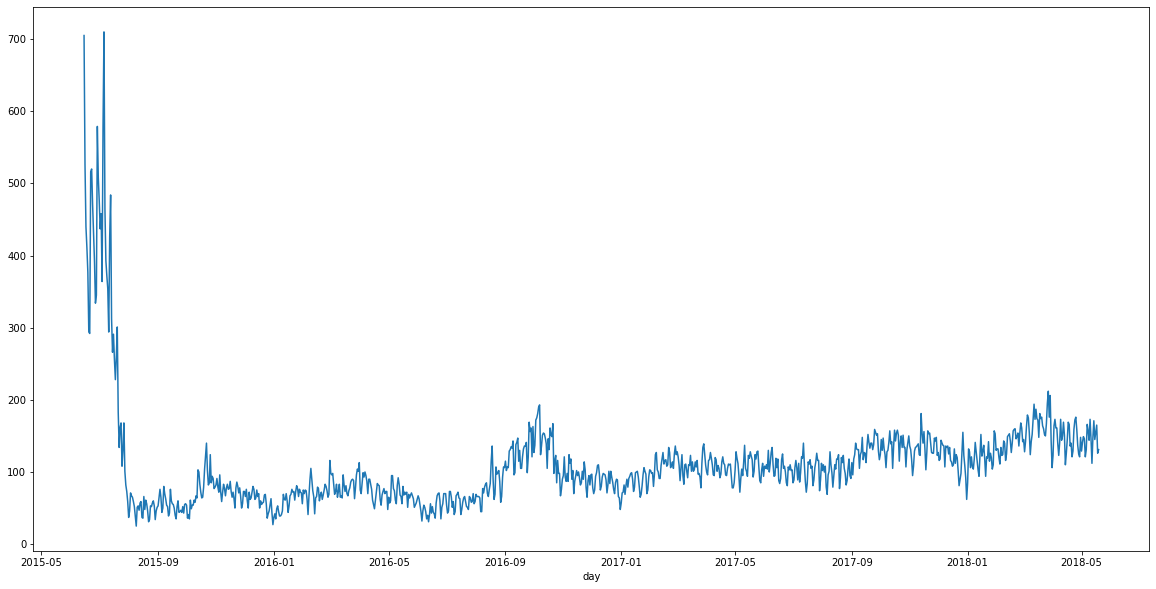

In [31]:
# Попробуем посмотреть на количество уникальных пользователей по дням
# За размер графика овтечает параметр figsize куда нужно передать кортеж ширина высота
df.groupby('day')['user_id'].nunique().plot(figsize=(20,10));

In [33]:
# Установка размера графика по умолчанию и по красивее получается
sns.set(rc={'figure.figsize':(9,6)})

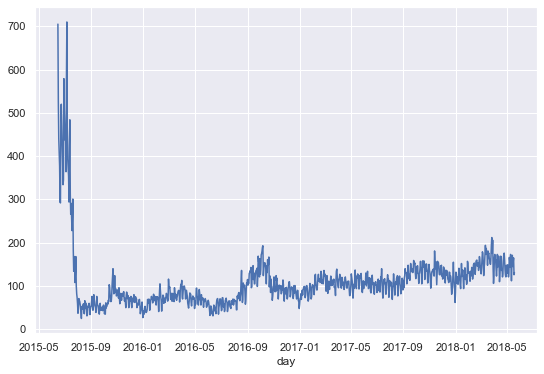

In [34]:
df.groupby('day')['user_id'].nunique().plot();

In [37]:
# Посмотрим пользователей которыые решили степы(задания)
# Для этого сгруппируем по user_id тех пользователей у которых хоть один степ имеет статус passed
users_passed_step = df[df['action']=='passed']
# Посчитаем количество сданых степов
users_passed_step.groupby('user_id',as_index=False).agg({'step_id':'count'})

,user_id,step_id
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84
...,...,...
17257,26789,2
17258,26790,8
17259,26794,69
17260,26797,10


In [ ]:
# Отметим что название столбца step_id неправльно отображает свою суть.
# Ведь сейчас в нем количество степов который сдал тот или иной пользователь
# Значит нужно переименовать его

In [44]:
count_users_passed_steps = users_passed_step.groupby(
    'user_id',as_index=False).agg(
    {'step_id':'count'}).rename(columns={'step_id':'count_passed_steps'})

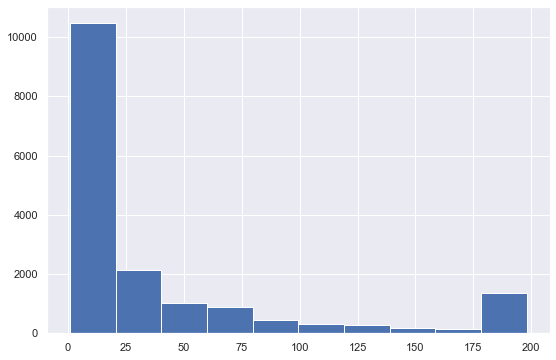

In [49]:
# Построим гистограмму
count_users_passed_steps['count_passed_steps'].hist();



In [51]:
count_users_passed_steps.head()

,user_id,count_passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Важный момент который надо запомнить на будущее.  Сейчас при группировке мы забыли про пользоватлей у которых вообще не было пройденных степов.
Для сравнения


In [54]:
df['user_id'].nunique(),count_users_passed_steps['user_id'].nunique()

(19234, 17262)

Как видим довольно солидный кусок пользователей пропал и не будет учитываться при построении модели, а это чревато неверными прогнозами. Поэтому на каждом этапе необходимо контролировать число наблюдений с котороми мы работаем.

In [ ]:
# Правильный путь это создание сводной таблицы - pivot_table

In [57]:
df.pivot_table(index='user_id',
              columns='action',
              values='step_id',
              aggfunc='count',
              fill_value=0).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


То есть мы используем в качестве индекса user_id. Все возможнные категории, которые у нас принимают значения в колонке action, в сводной таблице становятся колонками за это отвечает параметр columns.
values это колонка к которой мы будем применять агрегирующую функцию.
fill_value если нет значения в колонке то ставится 0.

In [61]:
# Улучшим читаемость перезагрузив индекс
# eset_index() в конце для того и делается, чтобы "user_id" не был индексом.
с = df.pivot_table(index='user_id',
              columns='action',
              values='step_id',
              aggfunc='count',
              fill_value=0).reset_index()

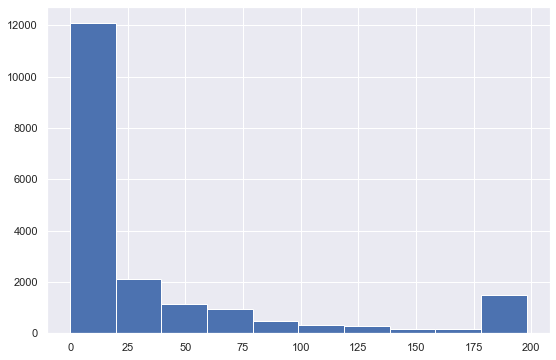

In [63]:
# Построим теперь гистограмму отражающую полную картину
с['discovered'].hist();

        Начнем работу с вторым датасетом. Проведем те же преобразования что и с первым.

In [66]:
df2 = pd.read_csv('data/submissions_data_train.zip',compression='zip') 

In [67]:
df2.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [72]:
# Добавим столбы data и day
df2['date'] = pd.to_datetime(df['timestamp'],unit='s')
df2['day'] = df2['date'].dt.date

In [73]:
df2.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 04:00:48,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 04:00:48,2015-06-15
2,31972,1478852149,wrong,15853,2015-06-15 04:00:48,2015-06-15
3,31972,1478852164,correct,15853,2015-06-15 04:01:35,2015-06-15
4,31976,1434348123,wrong,15853,2015-06-15 04:01:35,2015-06-15


In [78]:
# Сделаем сводную таблицу по правильным и неправильным ответам
users_scores = df2.pivot_table(index='user_id',
                   columns='submission_status',
                   values='step_id',
                   aggfunc='count',
                   fill_value =0 ).reset_index()

In [79]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Попробуем теперь определить сколько времени должно пройти с момента последнего входа пользователя на курс, чтобы считать этого пользователя покинувшим курс.

 Создадим датасет, куда отберем нужные признаки. Так как мы считаем по дням, то пользователь который был хотя бы раз за день будет считаться, это позволит нам убрать наблюдения когда пользователь был много раз на сайте за день. Сделать это можно с помощью drop_duplicates(которая убирает повторы).
 параметр subset -означает те колонки к которым мы применяем этот метод
 Группируем по user_id, к колонке timestamp применяем list.чтобы получить список значений.
 После этого применяем np.diff который возвращает разницу между соседями и в итоге получаем список списков.

In [108]:
gap_data = df[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])\
.groupby('user_id')['timestamp'].apply(list)\
.apply(np.diff).values

In [109]:
# Создаем series
gap_data = pd.Series(np.concatenate(gap_data,axis=0))

In [110]:
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

In [112]:
gap_data = gap_data/(24*60*80)

In [113]:
gap_data

0         42.045156
1         59.889314
2          1.584062
3          0.813455
4         24.035330
            ...    
97867    124.542439
97868      4.384210
97869      0.852882
97870      0.494957
97871     13.611024
Length: 97872, dtype: float64

In [114]:
df.shape

(3480703, 6)

In [115]:
df2.shape

(509104, 6)

In [116]:
df['user_id'].nunique(),df2['user_id'].nunique()

(19234, 9940)

In [122]:
df.groupby('user_id')['step_id'].count().max()

33043

In [123]:
c = df.pivot_table(index='user_id',
              columns='action',
              values='step_id',
              aggfunc='count',
              fill_value=0)

In [126]:
c.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


In [ ]:
# 